<a href="https://colab.research.google.com/github/Createdd/computervision_ue/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

available on 

## https://colab.research.google.com/drive/1UXrw17Lsbt-hsOIerbMG4JuFzpn73DWK

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 23 13:36:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/cv_data

/content/drive/MyDrive/cv_data


In [4]:
# !apt install unzip
# !unzip ./data_WiSAR.zip -d .

In [5]:
%ls

data/  data_WiSAR.zip  integrated/  logs/  model/


In [6]:
import torchvision
import torch
import torch.nn as nn

import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

!pip install ipython-autotime


# https://afagarap.github.io/2020/01/26/implementing-autoencoder-in-pytorch.html
# https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329
# https://medium.com/analytics-vidhya/anomaly-detection-in-images-autoencoders-b780abf88f51

## Load data


In [7]:
from torchvision import datasets, transforms

# data_dir = './data'
data_dir = './integrated'

train_dir = data_dir + '/train'
validation_dir = data_dir + '/validation'
test_dir = data_dir + '/test'


# DATA_DIR = 'data/train/train-1-0/0-B01.png'

# transform = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
# dataset = datasets.ImageFolder(data_dir, transform=transform)

# train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.5, 0.5, 0.5], 
#                                                            [0.5, 0.5, 0.5])])
train_transforms = transforms.Compose([
                                      #  transforms.Resize(1024), #225
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #  transforms.Normalize([0.5, 0.5, 0.5], 
                                      #                     [0.5, 0.5, 0.5])])
                                       transforms.Grayscale(num_output_channels=1),
                                      transforms.Normalize([0.5],  # if grayscale
                                                           [0.5])])

train_data = datasets.ImageFolder(train_dir, 
                                  transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, 
                                 transform=train_transforms)
validation_data = datasets.ImageFolder(validation_dir, 
                                  transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           shuffle=True,
                                          batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, 
                                         batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_data, 
                                         batch_size=32)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 26
    Root location: ./integrated/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Grayscale(num_output_channels=1)
               Normalize(mean=[0.5], std=[0.5])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


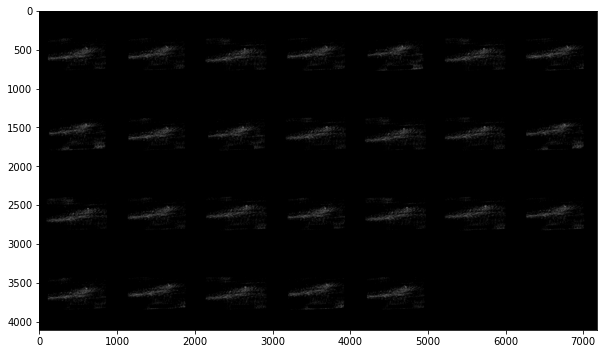

In [9]:
def imshow(img):
    plt.figure(figsize=(10,8))
    plt.imshow(img.permute(1,2,0))


image, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(image,nrow=7))

In [62]:
# import cv2

# def load_images_from_folder(folder):
    
#     images = []
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)
#         if len(images)>5:
#             break
    
#     plt.figure(figsize=(16,8))    
#     for img,x in zip(images,range(1,7)):
#         plt.subplot(2,3,x)
#         plt.imshow(img)


# for fold in os.walk(train_dir):
#   for im in fold[1]:
#     load_images_from_folder(train_dir+'/'+im)

time: 3.16 ms (started: 2021-12-23 14:46:07 +00:00)


## Build architecture

In [10]:
# import tensorflow as tf

# # Create the Encoder and Decoder
# #pass the gray scale input image of size(28,28,1)
# inputs = tf.keras.Input(shape=(28, 28, 1), name='input_layer')
# # Conv Block 1 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# # Conv Block 2 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# # Conv Block 3 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
# #Decoder
# # DeConv Block 1-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# # DeConv Block 2-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# # DeConv Block 3-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# # output
# outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [11]:
# import tensorflow as tf
# from tensorflow.keras import Model, Input, regularizers
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.preprocessing import image


# Input_img = Input(shape=(80, 80, 3))  
    
# #encoding architecture
# x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
# x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
# x3 = MaxPool2D(padding='same')(x2)
# x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
# x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
# x6 = MaxPool2D(padding='same')(x5)
# encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
# #encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# # decoding architecture
# x7 = UpSampling2D()(encoded)
# x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
# x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
# x10 = Add()([x5, x9])
# x11 = UpSampling2D()(x10)
# x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
# x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
# x14 = Add()([x2, x13])
# # x3 = UpSampling2D((2, 2))(x3)
# # x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# # x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
# decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

# autoencoder = Model(Input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [106]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.models import Model

target_size = (1024, 1024)
channel = (1,)
input_size = target_size + channel
batch_size=16


# input = layers.Input(shape=(28, 28, 1))
input = layers.Input(shape=input_size)


# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder

# autoencoder.compile(optimizer="adam", loss="binary_crossentropy")


def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

# autoencoder = tf.keras.Model(inputs, outputs)
autoencoder = Model(input, x)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)
# autoencoder = load_model('./model/autoencoder.h5')

autoencoder.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1024, 1024, 1)]   0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1024, 1024, 32)    320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 512, 512, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 512, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 512, 512, 32)     924

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator()
# train_it = datagen.flow_from_directory('data/train/', class_mode='binary', batch_size=64)

In [107]:
# todo create params and pass over variables
from keras.preprocessing.image import ImageDataGenerator

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

data_gen = ImageDataGenerator(rescale=1 / 255)

train_generator = data_gen.flow_from_directory(
    train_dir, 
    target_size = target_size,
    # classes=['1','2'],
    color_mode='grayscale', 
    class_mode='input', 
    batch_size=batch_size)#256)

test_generator = data_gen.flow_from_directory(
    test_dir, 
    target_size = target_size, 
    color_mode='grayscale', 
    class_mode='input', 
    batch_size=batch_size)

validation_generator = data_gen.flow_from_directory(
    validation_dir, 
    target_size = target_size, 
    color_mode='grayscale', 
    class_mode='input', 
    batch_size=batch_size)



Found 26 images belonging to 26 classes.
Found 13 images belonging to 13 classes.
Found 11 images belonging to 11 classes.
time: 320 ms (started: 2021-12-23 15:35:17 +00:00)


In [63]:
test_generator.samples

13

time: 6.93 ms (started: 2021-12-23 14:46:49 +00:00)


In [51]:
%load_ext tensorboard
%reload_ext tensorboard

from keras.callbacks import TensorBoard
import tensorflow as tf
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 7.02 ms (started: 2021-12-23 14:27:02 +00:00)


In [108]:
# https://keras.io/api/models/model_training_apis/
%load_ext autotime

hist=autoencoder.fit(
                x = train_generator,
                epochs=10,
                #batch_size=128, # doesnt need to be specified when generator is used
                #shuffle=True,
                validation_data=(validation_generator),
                callbacks=[tensorboard_callback]
                )


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 0.8209 - val_loss: 0.8153
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 0.8201 - val_loss: 0.8153
Epoch 3/10
2/2 [==============================] - 2s 2s/step - loss: 0.8200 - val_loss: 0.8152
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 0.8199 - val_loss: 0.8150
Epoch 5/10
2/2 [==============================] - 2s 2s/step - loss: 0.8198 - val_loss: 0.8149
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 0.8197 - val_loss: 0.8147
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.8195 - val_loss: 0.8145
Epoch 8/10
2/2 [==============================] - 2s 2s/step - loss: 0.8193 - val_loss: 0.8144
Epoch 9/10
2/2 [==============================] - 2s 2s/step - loss: 0.8191 - val_loss: 0.8141
Epoch 10/10
2/2 [==============================] - 3s 1s/step

In [17]:
# autoencoder.save('./model/autoencoder.h5')

time: 684 µs (started: 2021-12-23 13:38:25 +00:00)


In [18]:
# %tensorboard --logdir logs
# ## notebook.display(port=6006, height=1000) 

# from tensorboard import notebook
# notebook.list()

time: 730 µs (started: 2021-12-23 13:38:25 +00:00)


In [19]:
predictions = autoencoder.predict(test_generator)
decoded_imgs = predictions
# decoded_mnistimgs= autoencoder.predict(x_mnisttest)

time: 8.16 s (started: 2021-12-23 13:38:25 +00:00)


In [20]:
def display(array1, array2, target_size=(28,28)):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(target_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(target_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


time: 10 ms (started: 2021-12-23 13:38:33 +00:00)


In [21]:
# all_images = [next(test_generator) for _ in range(4)]
# all_images

time: 516 µs (started: 2021-12-23 13:38:33 +00:00)


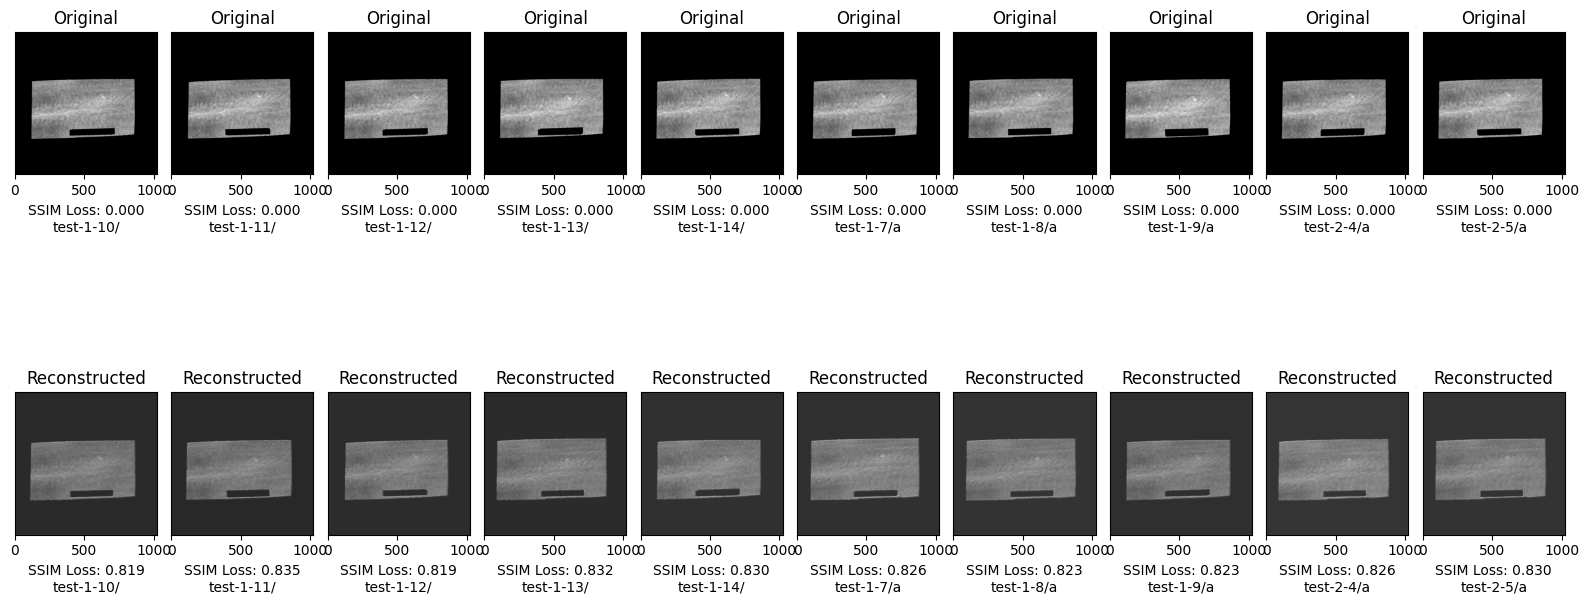

time: 7.26 s (started: 2021-12-23 15:44:03 +00:00)


In [120]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

n=10
for i in range(n):

    gen_file_name = test_generator.filenames[i]
    # a, b = iter_nth(test_generator, i)
    img = next(test_generator)[0][i]
    loss_orig = SSIMLoss(img,img) 
    # print(a.mean(), i)
    loss_reconstructed = SSIMLoss(img,predictions[i]) 

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a)
    plt.imshow(img.reshape(target_size))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    # value_a = SSIMLoss(next(test_generator)[0][i], next(test_generator)[0][i]) # loss should be zero
    ax.set_title(f"Original")
    label = f'SSIM Loss: {loss_orig:.3f}\n{gen_file_name[:10]}'
    ax.set_xlabel(label)
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(predictions[i].reshape(target_size))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False) 

    # value_a = SSIMLoss(predictions[i], next(test_generator)[0][i])
    ax.set_title(f"Reconstructed")
    label = f'SSIM Loss: {loss_reconstructed:.3f}\n{gen_file_name[:10]}'
    ax.set_xlabel(label)
    
    # Reconstructed anomalous data  vs Original training data
    # ax = plt.subplot(3, n, plt_a + 2*n)
    # plt.imshow(decoded_mnistimgs[i].reshape(28,28))
    # ax.get_xaxis().set_visible(True)
    # ax.get_yaxis().set_visible(False)
    # value = SSIMLoss(decoded_mnistimgs[i], decoded_imgs[i])
    # label = 'SSIM Loss value: {:.3f}'
    # ax.set_title("Anomal Image " )
    # ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

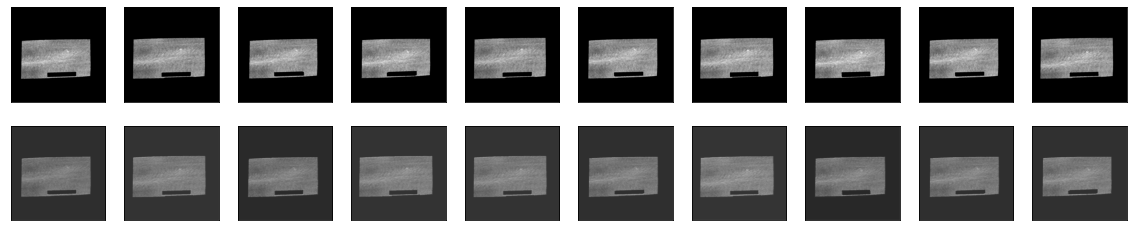

time: 2.89 s (started: 2021-12-23 14:47:28 +00:00)


In [65]:
display(next(test_generator)[0], predictions, target_size)

# new, label = next(test_generator)
# display(new, predictions)

In [24]:
predictions.shape[1]

1024

time: 3.47 ms (started: 2021-12-23 13:38:44 +00:00)


32/32 [==============================] - 0s 3ms/step


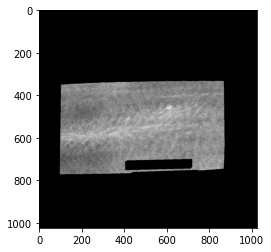

time: 411 ms (started: 2021-12-23 14:00:51 +00:00)


In [31]:
# next(test_generator)[0][0]
reconstruction = autoencoder.predict(input_sample, verbose=1)
reconstruction.shape


# plt.imshow(reconstruction, cmap='binary')
plt.imshow(np.expand_dims(input_sample, axis=0).reshape(target_size))

In [117]:
test_generator.samples

13

time: 4.14 ms (started: 2021-12-23 15:42:59 +00:00)


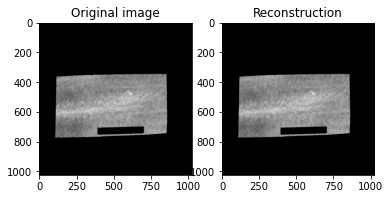

ValueError: ignored

time: 4.11 s (started: 2021-12-23 15:45:31 +00:00)


In [122]:
!pip install keract
from keract import get_activations, display_activations, display_heatmaps

input_sample = next(test_generator)[0][0]
# input_sample = X[0]
reconstruction = autoencoder.predict(input_sample)

img_width, img_height = 1024, 1024

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(6, 3.5)
# input_sample_reshaped = input_sample.reshape((img_width, img_height))
# reconsstruction_reshaped = reconstruction.reshape((img_width, img_height))
# axes[0].imshow(input_sample_reshaped) 
axes[0].imshow(input_sample.reshape(target_size))
axes[0].set_title('Original image')
# axes[1].imshow(reconsstruction_reshaped)
plt.imshow(np.expand_dims(input_sample, axis=0).reshape(target_size))
axes[1].set_title('Reconstruction')
plt.show()

In [124]:
activations = get_activations(autoencoder, input_sample, nested=True)
display_activations(activations, cmap="gray", save=False)
# display_heatmaps(activations, input_sample, save=False)

input_17 (1024, 1024, 1) -> Skipped. First dimension is not 1.
conv2d_6 (1024, 1024, 1, 32) -> Skipped. First dimension is not 1.
max_pooling2d_4 (1024, 512, 1, 32) -> Skipped. First dimension is not 1.
conv2d_7 (1024, 512, 1, 32) -> Skipped. First dimension is not 1.
max_pooling2d_5 (1024, 256, 1, 32) -> Skipped. First dimension is not 1.
conv2d_transpose_4 (1024, 512, 2, 32) -> Skipped. First dimension is not 1.
conv2d_transpose_5 (1024, 1024, 4, 32) -> Skipped. First dimension is not 1.
conv2d_8 (1024, 1024, 4, 1) -> Skipped. First dimension is not 1.
time: 941 ms (started: 2021-12-23 15:46:32 +00:00)


In [140]:
for layer_name, acts in activations.items():
        print(layer_name, acts.shape, end=' ')

input_17 (1024, 1024, 1) conv2d_6 (1024, 1024, 1, 32) max_pooling2d_4 (1024, 512, 1, 32) conv2d_7 (1024, 512, 1, 32) max_pooling2d_5 (1024, 256, 1, 32) conv2d_transpose_4 (1024, 512, 2, 32) conv2d_transpose_5 (1024, 1024, 4, 32) conv2d_8 (1024, 1024, 4, 1) time: 1.91 ms (started: 2021-12-23 15:57:08 +00:00)


----- trying  input_17
(1024, 1024, 1)
3
==


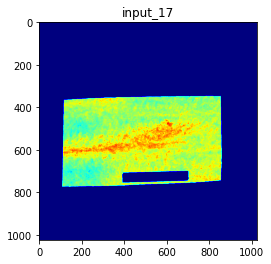

input_17 worked
----- trying  conv2d_6
(1024, 1024, 1, 32)
4
==
reframed:  (1024, 1024, 1)


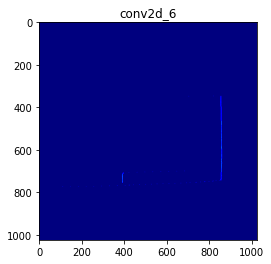

conv2d_6 worked
----- trying  max_pooling2d_4
(1024, 512, 1, 32)
4
==
reframed:  (1024, 512, 1)
max_pooling2d_4  didnt work
----- trying  conv2d_7
(1024, 512, 1, 32)
4
==
reframed:  (1024, 512, 1)
conv2d_7  didnt work
----- trying  max_pooling2d_5
(1024, 256, 1, 32)
4
==
reframed:  (1024, 256, 1)
max_pooling2d_5  didnt work
----- trying  conv2d_transpose_4
(1024, 512, 2, 32)
4
==
reframed:  (1024, 512, 2)


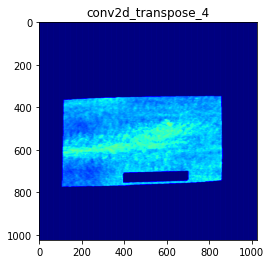

conv2d_transpose_4 worked
----- trying  conv2d_transpose_5
(1024, 1024, 4, 32)
4
==
reframed:  (1024, 1024, 4)
conv2d_transpose_5  didnt work
----- trying  conv2d_8
(1024, 1024, 4, 1)
4
==
reframed:  (1024, 1024, 4)
conv2d_8  didnt work
time: 718 ms (started: 2021-12-23 16:45:29 +00:00)


In [193]:
for layer_name, acts in activations.items():
    # acts = list(activations.items())[0]
    # act = acts[1]
    print('----- trying ', layer_name)
    print(acts.shape)
    print(len(acts.shape))
    print('==')
    
    
    try:
      if len(acts.shape) == 3:
        plt.imshow(np.expand_dims(acts, axis=0).reshape(target_size), cmap='jet')
        plt.title(layer_name)
        plt.show()
      else:
        print('reframed: ', acts[:,:,:,0].shape)
        plt.imshow(np.expand_dims(acts[:,:,:,0], axis=0).reshape(target_size), cmap='jet')
        plt.title(layer_name)
        plt.show()
      print(layer_name, 'worked')
    except: 
      print(layer_name,' didnt work')
    # new = act[0, :, 0]

AttributeError: ignored

<Figure size 720x576 with 0 Axes>

time: 38 ms (started: 2021-12-23 16:04:47 +00:00)


In [139]:
import math 

for layer_name, acts in activations.items():
        print(layer_name, acts.shape, end=' ')

        c=1
        nrows = int(math.sqrt(acts.shape[c]) - 0.001) + 1  # best square fit for the given number
        ncols = int(math.ceil(acts.shape[c] / nrows))
        hmap = None
        fig_size=(24, 24)
        data_format = 'channels_last'
        cmap="gray"
        


        fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=fig_size)
        for i in range(nrows * ncols):
            if i < acts.shape[c]:
                if len(acts.shape) == 3:
                    if data_format == 'channels_last':
                        img = acts[0, :, i]
                    elif data_format == 'channels_first':
                        img = acts[0, i, :]
                    else:
                        raise Exception('Unknown data_format.')
                    hmap = axes.flat[i].imshow([img], cmap=cmap)
                elif len(acts.shape) == 4:
                    if data_format == 'channels_last':
                        img = acts[0, :, :, i]
                    elif data_format == 'channels_first':
                        img = acts[0, i, :, :]
                    else:
                        raise Exception('Unknown data_format.')
                    hmap = axes.flat[i].imshow(img, cmap=cmap)
            axes.flat[i].axis('off')
        fig.suptitle(layer_name)
        fig.subplots_adjust(right=0.8)
        cbar = fig.add_axes([0.85, 0.15, 0.03, 0.7])
        if hmap is not None:
            fig.colorbar(hmap, cax=cbar)
            plt.show()
        # pyplot figures require manual closing
        index += 1
        plt.close(fig)

input_17 (1024, 1024, 1) 

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f29e6a01200> (for post_execute):


KeyboardInterrupt: ignored

time: 7.31 s (started: 2021-12-23 15:56:45 +00:00)


In [29]:
import scipy as sp


def plot_activation(img):
    pred = autoencoder.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    print(pred_class)
    weights = autoencoder.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(autoencoder.input,
                         autoencoder.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

time: 10.4 ms (started: 2021-12-23 14:00:32 +00:00)


In [30]:
new = np.expand_dims(input_sample, axis=0).reshape(target_size)
plot_activation(input_sample)


764740


IndexError: ignored

time: 351 ms (started: 2021-12-23 14:00:35 +00:00)


In [ ]:
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# print(classification_report(label_test, np.argmax(model.predict(test_generator),axis=1)))


In [ ]:
# from PIL import Image
# #img_data = np.random.random(size=(100, 100, 3))
# img = tf.keras.preprocessing.image.array_to_img(train_data)
# array = tf.keras.preprocessing.image.img_to_array(img)

# def preprocess(array):
#     """
#     Normalizes the supplied array and reshapes it into the appropriate format.
#     """

#     array = array.astype("float32") / 255.0
#     array = np.reshape(array, (len(array), 28, 28, 1))
#     return array

# new = preprocess(train_data)

In [ ]:
# batchX, batchy = train_it.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

# x_train = train_data.astype('float32') / 255.
# x_test = test_data.astype('float32') / 255.
# x_train = np.reshape(train_data, (len(train_data), 28, 28, 1))
# x_test = np.reshape(test_data, (len(test_data), 28, 28, 1))

In [ ]:
# not used anymore

# import itertools

# def iter_nth(iterable, nth):
#     return next(itertools.islice(iterable, nth, nth+1))

# new = iter_nth(test_generator, 2)
# len(new)

# name_2 = test_generator.filenames[2]
# a, b = iter_nth(test_generator, 2)
# new = SSIMLoss(a,a) 
# new.numpy()